# Image Analysis

VisualFeatures.CAPTION - Generate a human-readable sentence that describes the content of an image.

VisualFeatures.READ -  Also known as Optical Character Recognition (OCR). Extract printed or handwritten text from images. 
Note: For extracting text from PDF, Office, and HTML documents and document images, use the Document Intelligence service with the Read model. 

VisualFeatures.DENSE_CAPTIONS - Dense Captions provides more details by generating one-sentence captions for up to 10 different regions in the image, including one for the whole image.

VisualFeatures.TAGS - Extract content tags for thousands of recognizable objects, living beings, scenery, and actions that appear in images.

VisualFeatures.OBJECTS - Object detection. This is similar to tagging, but focused on detecting physical objects in the image and returning their location.

VisualFeatures.SMART_CROPS - Used to find a representative sub-region of the image for thumbnail generation, with priority given to include faces.

VisualFeatures.PEOPLE - Detect people in the image and return their location.

## Install Library

In [1]:
%pip install azure-ai-vision-imageanalysis

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.9/198.9 kB 20.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Helper Functions

In [1]:
from matplotlib import pyplot as plt
import cv2

# Function to display an image.
def show_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

    # Convert the image from BGR to RGB for displaying with matplotlib,
    # because OpenCV uses BGR by default and matplotlib expects RGB.
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image with matplotlib.
    plt.imshow(img_rgb)
    plt.axis("off")  # Turn off axis labels.
    plt.show()

In [2]:
from PIL import Image, ImageDraw, ImageFont

# Function to display an image with bounding boxes based on the analysis result.
def show_image_with_boxes(image_path, result, type):
    # Load the image
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)

     # Define the font and size
    font = ImageFont.truetype("DejaVuSans-Bold.ttf", 40)  # You can adjust the font size as needed

    if type == "objects":
        if result.objects is not None:
            for object in result.objects.list:
                # Draw bounding box
                box = object.bounding_box
                draw.rectangle([(box['x'], box['y']), (box['x'] + box['w'], box['y'] + box['h'])], outline="red", width=2)
                draw.text((box['x'], box['y'] - 10), f"{object.tags[0].name} ({object.tags[0].confidence:.2f})", fill="red", font=font)
    elif type == "people":
        if result.people is not None:
            for person in result.people.list:
                # Draw bounding box
                box = person.bounding_box
                draw.rectangle([(box['x'], box['y']), (box['x'] + box['w'], box['y'] + box['h'])], outline="red", width=2)
                draw.text((box['x'], box['y'] - 10), f"Confidence {person.confidence:.2f}", fill="red", font=font)
    elif type == "text":
        if result.read is not None:
            for line in result.read.blocks[0].lines:
                for word in line.words:
                    # Draw rectangle over the word
                    bounding_box = word.bounding_polygon
                    draw.polygon([(point['x'], point['y']) for point in bounding_box], outline="red" , width=3)

    # Save or display the image with bounding boxes
    image.show()  # To display the image
    # image.save("output_image_with_boxes.jpg")  # To save the image

## Load Azure Configuration

In [3]:
import os
azure_computer_vision_endpoint = os.environ["AZURE_COMPUTER_VISION_ENDPOINT"]
azure_computer_vision_key = os.environ["AZURE_COMPUTER_VISION_KEY"]

## Show Image and Create Client

https://learn.microsoft.com/en-us/python/api/overview/azure/ai-vision-imageanalysis-readme?view=azure-python

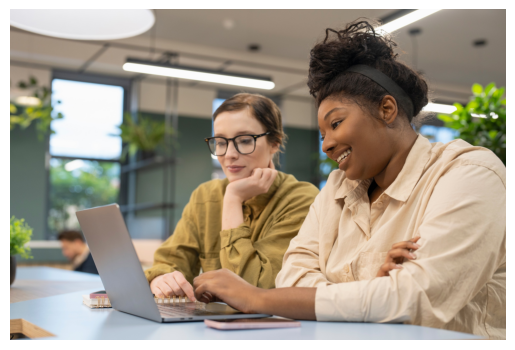

In [4]:
from azure.ai.vision.imageanalysis import ImageAnalysisClient
from azure.ai.vision.imageanalysis.models import VisualFeatures
from azure.core.credentials import AzureKeyCredential

image = "../Data/images/analyze_image.jpg"
show_image(image)

# Read the image file as bytes
with open(image, "rb") as image_file:
    image_data = image_file.read()

# Create an Image Analysis client
client = ImageAnalysisClient(
    endpoint=azure_computer_vision_endpoint,
    credential=AzureKeyCredential(azure_computer_vision_key)
)

## Caption, Dense Captions, Tags

Possible list of visual features: https://learn.microsoft.com/en-us/python/api/azure-ai-vision-imageanalysis/azure.ai.vision.imageanalysis.models.visualfeatures?view=azure-python

In [5]:
# Get the feature for the image. This will be a synchronously (blocking) call.
result = client.analyze(
    image_data=image_data,
    visual_features=[VisualFeatures.CAPTION, VisualFeatures.DENSE_CAPTIONS, VisualFeatures.TAGS],
    gender_neutral_caption=True,  # Optional (default is False)
)

print("Caption:")
if result.caption is not None:
    print(f"   '{result.caption.text}', Confidence {result.caption.confidence:.4f}")

print("Dense Captions:")
for item in result.dense_captions['values']:
    print(f"   '{item['text']}', Confidence {item['confidence']:.4f}")

print("Tags:")
for item in result.tags['values']:
    print(f"   '{item['name']}', Confidence {item['confidence']:.4f}")

Caption:
   'a person looking at a laptop', Confidence 0.7595
Dense Captions:
   'a person looking at a laptop', Confidence 0.7594
   'a group of women sitting at a table looking at a laptop', Confidence 0.7911
   'a person's hands on a laptop', Confidence 0.6996
   'blur a blurry picture of a window', Confidence 0.7642
   'a close-up of a person's eyes', Confidence 0.8578
   'a person in glasses looking at a laptop', Confidence 0.7607
   'a blurry image of a tree', Confidence 0.7732
   'blur a blurry image of a computer screen', Confidence 0.7552
   'a person smiling at something', Confidence 0.7115
   'a close-up of a person wearing glasses', Confidence 0.8501
Tags:
   'person', Confidence 0.9954
   'clothing', Confidence 0.9926
   'human face', Confidence 0.9857
   'indoor', Confidence 0.9455
   'laptop', Confidence 0.9270
   'computer', Confidence 0.9075
   'sitting', Confidence 0.8756
   'office building', Confidence 0.8481
   'woman', Confidence 0.6517


## Objects

In [ ]:
# Get the feature for the image. This will be a synchronously (blocking) call.
result = client.analyze(
    image_data=image_data,
    visual_features=[VisualFeatures.OBJECTS],
    gender_neutral_caption=True,  # Optional (default is False)
)

 # Print Objects analysis results to the console
print(" Objects:")
if result.objects is not None:
    for object in result.objects.list:
        print(f"   '{object.tags[0].name}', {object.bounding_box}, Confidence: {object.tags[0].confidence:.4f}")
print(f" Image height: {result.metadata.height}")
print(f" Image width: {result.metadata.width}")

show_image_with_boxes(image, result, "objects")

## Smart Crops

Thumbnails often need to have a certain aspect ratio, where aspect ratio is defined as the width in pixels divided by the height in pixels. For example, 1.0 for a square image, or 1.77 for a 16:9 widescreen image.

You can optionally request one or more aspect ratios by setting the `smart_crops_aspect_ratios` argument in the call to `analyze`. Supported values are from 0.75 to 1.8 (inclusive).

If you do not set this value, the service will return one result with an aspect ratio it sees fit between 0.5 and 2.0 (inclusive).

In [ ]:
# Do Smart Cropping analysis on an image stream. This will be a synchronously (blocking) call.
result = client.analyze(
    image_data=image_data,
    visual_features=[VisualFeatures.SMART_CROPS],
    smart_crops_aspect_ratios=[1.0],  # Optional. Specify one more desired aspect ratios    
)

if result.smart_crops is not None:
    for smart_crop in result.smart_crops.list:
        print(f"Aspect ratio {smart_crop.aspect_ratio}: Smart crop {smart_crop.bounding_box}")
print(f" Image height: {result.metadata.height}")
print(f" Image width: {result.metadata.width}")


## Show Cropped Image

In [ ]:
from PIL import Image

# Load the original image
original_image = Image.open(image)

# Define the bounding box (x, y, w, h)
# you need to adjust the bounding box based on the smart crop result
bounding_box = {'x': 957, 'y': 0, 'w': 2270, 'h': 2271}

# Crop the image using the bounding box
cropped_image = original_image.crop((bounding_box['x'], bounding_box['y'], 
                                     bounding_box['x'] + bounding_box['w'], 
                                     bounding_box['y'] + bounding_box['h']))

# Display the cropped image
cropped_image.show()

## People

In [ ]:
# Find people in an image stream. This will be a synchronously (blocking) call.
result = client.analyze(
    image_data=image_data,
    visual_features=[VisualFeatures.PEOPLE]
)

# Print People analysis results to the console
print(" People:")
if result.people is not None:
    for person in result.people.list:
        print(f"   {person.bounding_box}, Confidence {person.confidence:.4f}")
print(f" Image height: {result.metadata.height}")
print(f" Image width: {result.metadata.width}")

show_image_with_boxes(image, result, "people")

## Text

In [ ]:
image = "../Data/images/ocr.jpg"
show_image(image)

# Read the image file as bytes
with open(image, "rb") as image_file:
    image_data = image_file.read()


# Extract text (OCR) from an image stream. This will be a synchronously (blocking) call.
result = client.analyze(
    image_data=image_data,
    visual_features=[VisualFeatures.READ]
)

# Print text (OCR) analysis results to the console
print(" Read:")
if result.read is not None:
    for line in result.read.blocks[0].lines:
        print(f"   Line: '{line.text}', Bounding box {line.bounding_polygon}")
        for word in line.words:
            print(f"     Word: '{word.text}', Bounding polygon {word.bounding_polygon}, Confidence {word.confidence:.4f}")

print(f" Image height: {result.metadata.height}")
print(f" Image width: {result.metadata.width}")

show_image_with_boxes(image, result, "text")